# Overview

This tutorial uses the iowa liquor sales data which has about 24 million rows. The goal of this notebook given a liquor's:
* pack size(#bottle per pack)
* retail cost per bottle
* quantity sold

predict it's future sales price based on the previous years sales data using a tree based ML estimators: Random Forest


In [ ]:
%%capture

# Installing the required libraries:
!pip install matplotlib pandas scikit-learn tensorflow pyarrow tqdm
!pip install google-cloud-bigquery google-cloud-bigquery-storage
!pip install flake8 pycodestyle pycodestyle_magic
!pip install scikit-plot

In [ ]:
# Python Builtin Libraries
from datetime import datetime

#import Classic ML
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Third Party Libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurations
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Authentication
In order to run this tutorial successfully, we need to be authenticated first. 

Depending on where we are running this notebook, the authentication steps may vary:

| Runner      | Authentiction Steps |
| ----------- | ----------- |
| Local Computer      |  Use a service account, or run the following command: <br><br>`gcloud auth login`    |
| Colab   | Run the following python code and follow the instructions: <br><br>`from google.colab import auth` <br> `auth.authenticate_user()     `    |
| Vertext AI (Workbench)   | Authentication is provided by Workbench       |

In [ ]:
try:
    from google.colab import auth

    print('Authenticating in Colab')
    auth.authenticate_user()
    print('Authenticated')
except:  # noqa
    print('This notebook is not running on Colab.')
    print('Please make sure to follow the authentication steps.')

Authenticating in Colab
Authenticated


### Configurations

Let's make sure we enter the name of our GCP project in the next cell.

In [ ]:
# ENTER THE GCP PROJECT HERE
gcp_project = YOUR_GCP_PROJECT
print(f'gcp_project is set to {gcp_project}')

# ENTER YEAR TO PREDICT
YEAR_TO_PREDICT = 2021
print(f'The year to predict is set to {YEAR_TO_PREDICT}')  

gcp_project is set to gcp-public-data-contributors
The year to predict is set to 2021


## Data Preparation

> I will do most of the preprocessing of the data in the query. For consistency and uniqueness of values, I will format the strings in city and category_name columns to lowercase. (e.g Davenport, DAVENPORT, davenport, should not be taken as differents city names). Making also sure there is no Nan values in the dataset

In [ ]:
#Pulling 20% of the data
query = '''
  SELECT
    date, LOWER(city) AS city, LOWER(category_name) AS category_name,
    pack,state_bottle_retail, bottles_sold, sale_dollars
  FROM
    `bigquery-public-data.iowa_liquor_sales.sales` TABLESAMPLE SYSTEM (20 PERCENT)
  WHERE city IS NOT NULL
  AND category_name IS NOT NULL
  AND pack IS NOT NULL
  AND bottles_sold IS NOT NULL
  AND sale_dollars IS NOT NULL
  AND state_bottle_retail IS NOT NULL;
'''

In [ ]:
bqclient = bigquery.Client(project=gcp_project)
dataframe = bqclient.query(query).result().to_dataframe()

### Check the Dataframe



> Let's look at the first 5 rows of the dataset

In [ ]:
dataframe.head()

,date,city,category_name,pack,state_bottle_retail,bottles_sold,sale_dollars
0,2019-09-24,davenport,gold rum,6,11.76,72,846.72
1,2018-08-31,muscatine,coffee liqueurs,24,9.74,1,9.74
2,2021-04-01,cedar rapids,single malt scotch,12,60.02,7,420.14
3,2014-11-05,ames,peach schnapps,12,11.43,4,45.72
4,2020-05-21,waukee,neutral grain spirits,8,13.13,16,210.08


> Next, we will get some basic information about the dataset

In [ ]:
#Exploring the categorical data
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4257329 entries, 0 to 4257328
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 object 
 1   city                 object 
 2   category_name        object 
 3   pack                 int64  
 4   state_bottle_retail  float64
 5   bottles_sold         int64  
 6   sale_dollars         float64
dtypes: float64(2), int64(2), object(3)
memory usage: 227.4+ MB


### Process the Dataframe

> Convert the date column from object dtype to datetime  tranform the entries to extract the month and year. then drop original date feature

In [ ]:
dataframe['date'] = dataframe['date'].astype('datetime64[ns]')

#Extracting the year and month from datetime object for manipulation
dataframe['year'] = dataframe['date'].dt.year
dataframe['month'] = dataframe['date'].dt.month

#Drop original date column
del dataframe['date']

> Since categorical data such as the liquor's category_name and the city  will not help in our prediction using the Random Forest estimator, I will drop those features and eliminate the need for doing lot of data engineering

In [ ]:
#Delete orginal category_name column
del dataframe['city']
del dataframe['category_name']

## Splitting data based on Year

>Since we aim to predict the sales value of  liquors at some point in future years, we will plot and look at the distribution of the data YOY to inform our split

Text(0.5, 1.0, 'Count for Year')

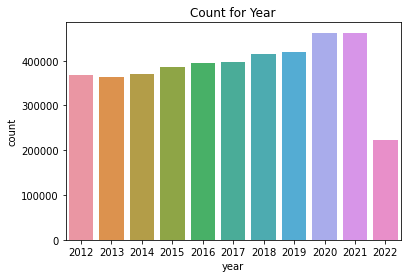

In [ ]:
#Taking a look at the distribution of the years visually
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='year', data=dataframe)
plt.title('Count for Year')


  *   The data from 2012 to 2020 will serve as Training
  * Testing will be performed on the data from 2021








In [ ]:
# Spliting the data.
train = dataframe[dataframe['year'] < YEAR_TO_PREDICT]
test = dataframe[dataframe['year'] == YEAR_TO_PREDICT]

> Separting Input features from Target features in both the training data and the testing data

In [ ]:
# Training data
Y_train = train['sale_dollars']
X_train = train.drop('sale_dollars', axis=1)

# Test Data
Y_test = test['sale_dollars']
X_test = test.drop('sale_dollars', axis=1)

## Train and Predict




 > Training with Random Forest

In [ ]:
randf_estimator = RandomForestRegressor()
#Train
randf_estimator.fit(X_train, Y_train)
#Predict
y_pred = randf_estimator.predict(X_test)

>Predictions & Accuracy of our model

In [ ]:
print('Scores on the test dataset\n')
#Test set predictions
acc_test = round(np.float64(r2_score(Y_test, y_pred) * 100), 2)
print(f'test r2_score is:    {acc_test}%')
print(f'test abs mean error: {round(mean_absolute_error(Y_test, y_pred), 2)}')
print(f'test RMSE:           {round(np.sqrt(mean_squared_error(Y_test, y_pred)), 2)}')

Scores on the test dataset

test r2_score is:    94.22%
test abs mean error: 1.98
test RMSE:           137.52


In [ ]:
print('Predictions on the test dataset\n')
#Printing the results for our test dataset
print('==========================================================')
y_pred = np.round(np.float64(y_pred), 2)
test_diff = (Y_test - y_pred)/Y_test
predictions = pd.DataFrame({'Predicted Price': y_pred, 'Actual Price': Y_test, 'Difference': test_diff})
predictions.head(10)

Predictions on the test dataset



,Predicted Price,Actual Price,Difference
2,364.97,420.14,0.131313
19,356.71,351.36,-0.015227
29,217.80,217.80,0.000000
58,356.71,351.36,-0.015227
59,540.00,540.00,0.000000
75,247.58,265.32,0.066863
79,531.18,531.18,0.000000
83,118.16,119.16,0.008392
84,282.85,270.00,-0.047593
85,668.79,669.60,0.001210


## Feature Importance Plotting

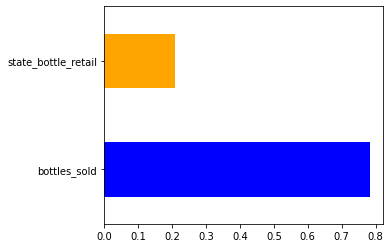

In [ ]:
colors=['blue', 'orange']
plt.subplots(figsize=(5,4))
feat_importances = pd.Series(randf_estimator.feature_importances_, index=X_train.columns)
feat_importances.nlargest(2).plot(kind='barh', color=colors);

As we can see from the plot above, the prediction was mostly influenced by the number bottles sold, then cost that state paid per bottle to the maker of the liquor.

This conclude our tutorial. we can now predict with some confidence, how much a particular liquor is going to sell for at a given month of a future year